In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy 
import netCDF4 as ncd
import random
import os
import cmocean as cmo

In [2]:
def getlat(f):
    return (180/np.pi)*(np.arcsin(24*60*60*f/(4*np.pi)))


def stable_v(x, us):
    #y = (-0.1448 / (x-1.12 + 0.476/(x-0.589))) #+ 0.0016
    y = (-1.765 / (x-0.6 + 1.66/(x-1.411))) #+ 0.0016
    y = -0.17658/((x-1.474)+0.330/(x-0.449))
    return y, us

def stable_v2(x, us):
    y = -0.176 / ( (x - 1.474) + ( 0.2025 / (x-0.45)   )  )
    return y, us

def model_function(x, a, b, c): # stable v0m
    return   -a / ( (x - b) + ( (c**2) / (x-c)   )  )
#array([ 0.14259197, -0.04343505,  1.80668134])


def unstable_v(B,u,f):
    p2 = f/(7.2921E-05)
    p3 = (0.0984/u)*np.sqrt(B/(7.2921e-05))
    p4 = 45* np.exp(-p2/0.35) + 3.29
 
    LV_dummy  = (p3 / ( 1 + (f * p4 * u*u)/B   ) ) + 0.0764 
    return LV_dummy, u

# -1.81845544,  1.12086881, -0.47616618,  0.58931308
def stable_h(x):
    c15,c16,c17,c18 = -1.81845544,  1.12086881, -0.47616618,  0.58931308
    y = c15 / ( x + c16 + c17/(x+c18) )
    return y

def unstable_h(x):
    y = c19 / ( c20 + c21/(x**2) ) + c22
    return y
cwd=os.getcwd()
cwd

# Define the colorbar artist for the legend
class ColorbarLegendArtist:
    def __init__(self, cmap, vmin, vmax):
        self.cmap = cmap
        self.norm = plt.Normalize(vmin, vmax)

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        # Create a mini colorbar as a horizontal gradient
        gradient = np.linspace(0, 1, 256).reshape(1, -1)
        ax = handlebox.get_axes()
        image = ax.imshow(
            gradient,
            aspect='auto',
            cmap=self.cmap,
            norm=self.norm,
            extent=[handlebox.xdescent, handlebox.xdescent + handlebox.width,
                    handlebox.ydescent, handlebox.ydescent + handlebox.height],
            transform=ax.transAxes,
            zorder=0
        )
        return image

In [4]:
b0m = np.loadtxt('nn_output_N2/fbu.txt')[:,1]
condition = (b0m > 0.0)
ind_m_u = np.where(condition)[0]
b0m = np.loadtxt('nn_output_N2/fbu.txt')[:,1]
condition = (b0m < 0.0)
ind_m_s = np.where(condition)[0]

v0ms = np.loadtxt('nn_output_N2/v_nn.txt')[ind_m_s]
v0mts = np.loadtxt('nn_output_N2/v_true_data.txt')[ind_m_s]
f0ms = np.loadtxt('nn_output_N2/fbu.txt')[ind_m_s,0]
u0ms = np.loadtxt('nn_output_N2/fbu.txt')[ind_m_s,2]
b0ms = np.loadtxt('nn_output_N2/fbu.txt')[ind_m_s,1]

v0mu = np.loadtxt('nn_output_N2/v_nn.txt')[ind_m_u]
v0mtu = np.loadtxt('nn_output_N2/v_true_data.txt')[ind_m_u]
f0mu = np.loadtxt('nn_output_N2/fbu.txt')[ind_m_u,0]
u0mu = np.loadtxt('nn_output_N2/fbu.txt')[ind_m_u,2]
b0mu = np.loadtxt('nn_output_N2/fbu.txt')[ind_m_u,1]

x0ms = (1/u0ms)*np.sqrt(np.abs(b0ms)/f0ms)
v0ms_eq = model_function(-x0ms, 0.14259197, -0.04343505,  1.80668134)
#v0ms_eq = v0ms_eq * u0ms

x0mu = (1/u0mu)*np.sqrt(np.abs(b0mu)/f0mu)
v0mu_eq, _ = unstable_v(b0mu,u0mu,f0mu)

b0 = np.loadtxt('nn_output_N3/fbu.txt')[:,1] #[:1666670,1]
condition = (b0 > 0.0)
ind_u = np.where(condition)[0]
b0 = np.loadtxt('nn_output_N3/fbu.txt')[:,1] #[:1666670,1]
condition = (b0 < 0.0)
ind_s = np.where(condition)[0]

v0s = np.loadtxt('nn_output_N3/v_nn.txt')[ind_s]
v0ts = np.loadtxt('nn_output_N3/v_true_data.txt')[ind_s]
f0s = np.loadtxt('nn_output_N3/fbu.txt')[ind_s,0]
u0s = np.loadtxt('nn_output_N3/fbu.txt')[ind_s,2]
h0s = np.loadtxt('nn_output_N3/fbu.txt')[ind_s,3]
b0s = np.loadtxt('nn_output_N3/fbu.txt')[ind_s,1]

v0u = np.loadtxt('nn_output_N3/v_nn.txt')[ind_u]
v0tu = np.loadtxt('nn_output_N3/v_true_data.txt')[ind_u]
f0u = np.loadtxt('nn_output_N3/fbu.txt')[ind_u,0]
u0u = np.loadtxt('nn_output_N3/fbu.txt')[ind_u,2]
h0u = np.loadtxt('nn_output_N3/fbu.txt')[ind_u,3]
b0u = np.loadtxt('nn_output_N3/fbu.txt')[ind_u,1]

x0s = ((np.abs(b0s)*h0s)**(1/3)) / u0s
v0s_eq = stable_h(x0s)


In [5]:
xs = (np.abs(b0s*h0s)**(1/3)/(u0s))
ys = v0s/u0s

xu = (np.abs(b0u*h0u)**(1/3)/(u0u))
yu = v0u/u0u

from scipy.optimize import curve_fit
def stable_h(x, a, b, c, d):
    return a / (b * (np.abs(x)**3) + c * np.abs(x) + d)

def unstable_h(x, a,b,c,d):
    return (a*np.abs(x) / ( b + (c/x**2) )) + d

# Fit the model to the data
popt_s, pcov = curve_fit(stable_h, xs, ys, p0=[0.103, 0.81, 0.13122,  1.2475])
ys_eq_pred = stable_h(xs, popt_s[0], popt_s[1], popt_s[2], popt_s[3])

popt_u, pcov = curve_fit(unstable_h, xu, yu, p0=[1, 6.01, 16.01, 0.0785])
yu_eq_pred = unstable_h(xu, 1, 6.01, 16.01, 0.0785) # popt_u[0], popt_u[1], popt_u[2], popt_u[3])


In [6]:
### comparing between v0m and v0

def getting_v0_v0m_stable(f,b,u,h):
    x1=(1/u) * np.sqrt( np.abs(b) / f) #-x0ms, 0.14259197, -0.04343505,  1.80668134)
    v0m_compare =  model_function(-x1, 0.14259197, -0.04343505,  1.80668134)
    
    x2=(np.abs(b*h)**(1/3)/(u))
    v0_compare  =  stable_h(x2, 0.60281709, 5.44736365, 0.30272706, 7.66617802)
    
    return v0m_compare*u, v0_compare*u

def getting_v0_v0m_unstable(f,b,u,h):
    x1=(1/u) * np.sqrt( np.abs(b) / f)
    
    v0m_compare, _ = unstable_v(b,u,f)
    
    x2=(np.abs(b*h)**(1/3)/(u))
    v0_compare  =  unstable_h(x2, 1, 6.01, 16.01, 0.0785)
    
    return v0m_compare*u, v0_compare*u

In [7]:
v1m, v1 = getting_v0_v0m_stable(f0s,b0s,u0s,h0s)   # f0s, 
v2m, v2 = getting_v0_v0m_unstable(f0u,b0u,u0u,h0u) 

/var/folders/hj/m15y48xs27nctzmq2564xygw0000gp/T/ipykernel_76104/865176704.py:81: UserWarning: The following kwargs were not used by contour: 'rasterized'
  contour = plt.contourf(p1x, p2y, sm.T, levels=levels, cmap=cmap2, rasterized=True)
/var/folders/hj/m15y48xs27nctzmq2564xygw0000gp/T/ipykernel_76104/2882250562.py:2: RuntimeWarning: invalid value encountered in arcsin
  return (180/np.pi)*(np.arcsin(24*60*60*f/(4*np.pi)))
/var/folders/hj/m15y48xs27nctzmq2564xygw0000gp/T/ipykernel_76104/2882250562.py:2: RuntimeWarning: invalid value encountered in arcsin
  return (180/np.pi)*(np.arcsin(24*60*60*f/(4*np.pi)))
/var/folders/hj/m15y48xs27nctzmq2564xygw0000gp/T/ipykernel_76104/865176704.py:354: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


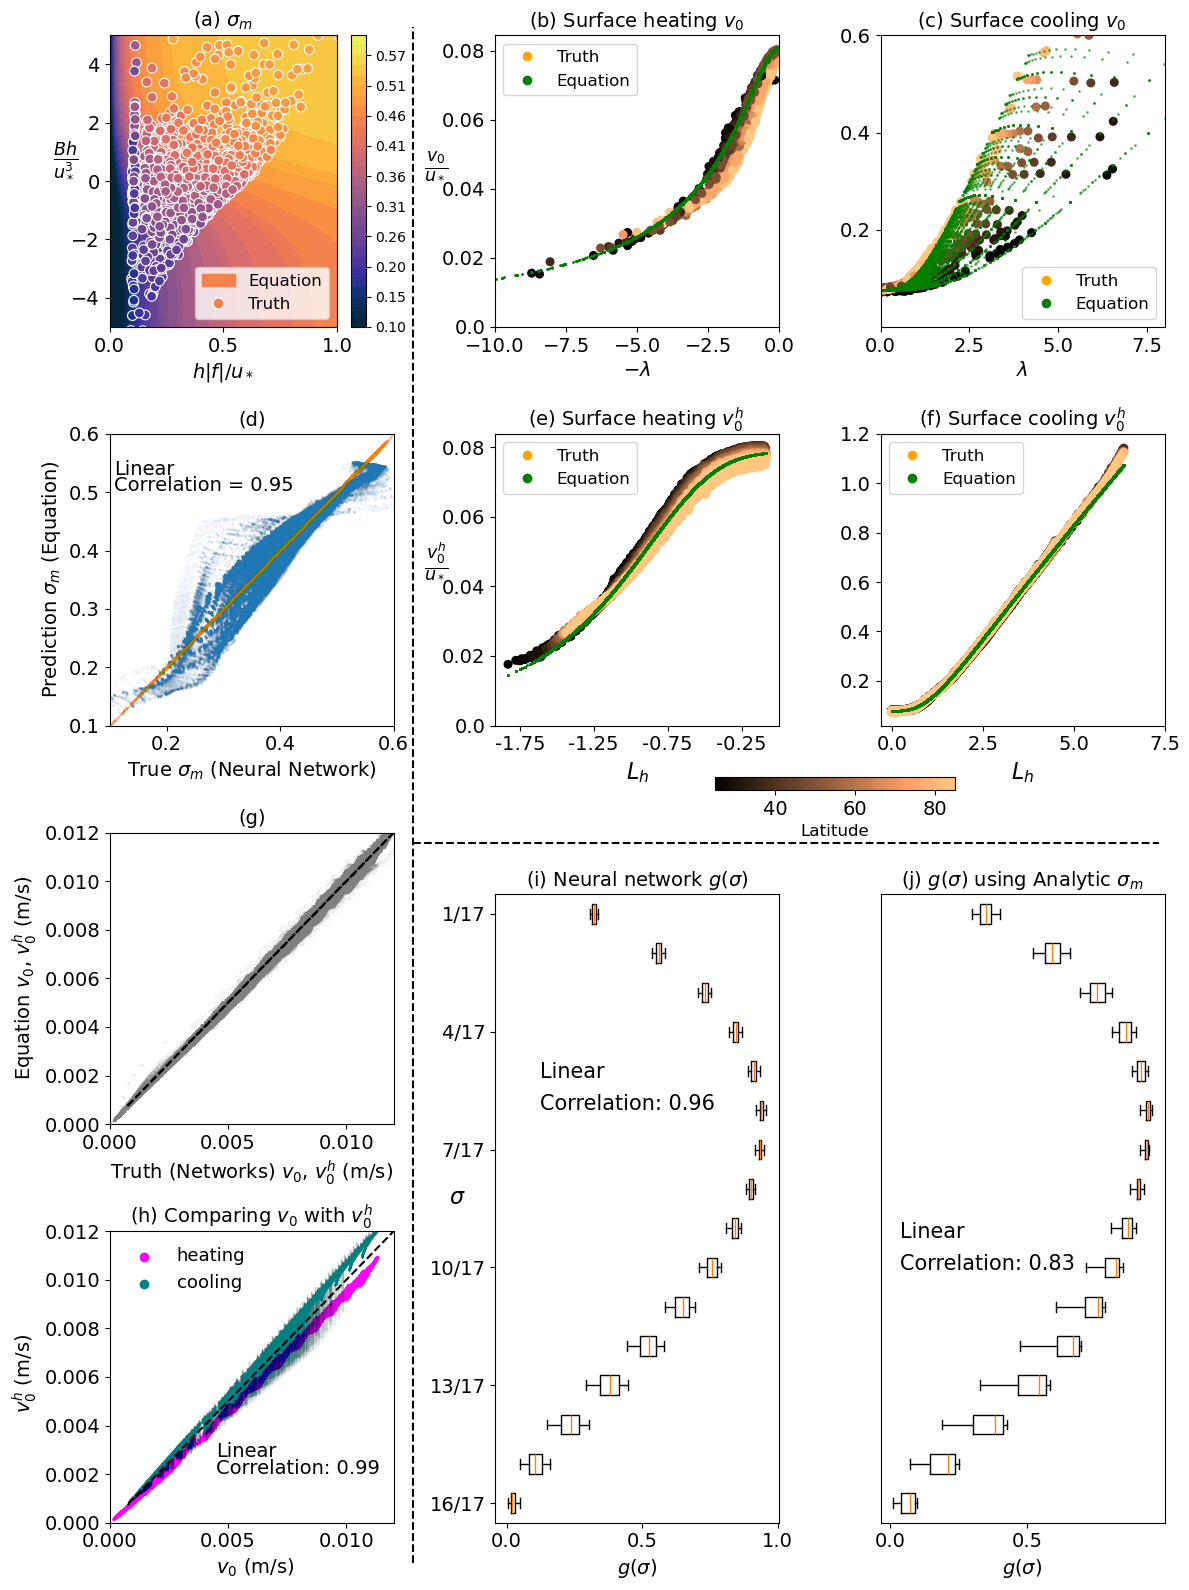

In [8]:
### Combined figures:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPathCollection

from matplotlib.lines import Line2D

plt.figure(figsize=(12,16))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Set custom sizes
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Define custom brown colormap
plt.set_cmap('copper')    # ('plasma')
lin_color = 'green'
lab_font_size = 14
tick_font_size = 14 # previous = 10  # Define tick label font size

plt.subplots_adjust(wspace=0.3, hspace=0.5)
# Define custom brown colormap
plt.set_cmap('copper')    # ('plasma')
lin_color = 'green'
lab_font_size = 14
tick_font_size = 10  # Define tick label font size

####
####

dictt=np.load('my_file.npy',allow_pickle=True) 
dictt=dictt.item()

p1x=dictt['p1x']
p2y=dictt['p2y']

p1=dictt['p1']
p2=dictt['p2']

sm=dictt['sm']
sm_NN=dictt['sm_NN']
sm_fit=dictt['sm_fit']


### Shape function stuff:

nn_t = np.loadtxt('SFData/y_true_4_32_32_16.txt')
nn_p = np.loadtxt('SFData/y_pred_4_32_32_16.txt')

k_nn = np.zeros(16)
k_nn = np.mean(nn_t,axis=0)

sftruth = np.loadtxt('SFData/sftruth.txt')
ypred_sm_fit = np.loadtxt('SFData/ypred_sm_fit.txt')

# Set custom sizes
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Define custom brown colormap
plt.set_cmap('copper')    # ('plasma')
lin_color = 'green'
lab_font_size = 14
tick_font_size = 14 # previous = 10  # Define tick label font size

## Plots starts here:

plt.subplot(431)

cmap2 = cmo.cm.thermal
levels = np.round(np.linspace(0.1, 0.60, 30), 2)

contour = plt.contourf(p1x, p2y, sm.T, levels=levels, cmap=cmap2, rasterized=True)
cbar = plt.colorbar(contour)
cbar.ax.tick_params(labelsize=10)

plt.xlim([0, 1.0])
plt.ylim([-5, 5])
plt.xlabel(r'$h|f| / u_*$', fontsize=lab_font_size)
plt.ylabel(r'$\frac{Bh}{u_*^3}$', rotation=0, fontsize=lab_font_size + 4)

N = 300
sc = plt.scatter(p1[::N], p2[::N], c=sm_NN[::N], s=50, vmin=0.1, vmax=0.7,
                 edgecolors='white', linewidths=0.8, cmap=cmap2,
                 label='Truth', rasterized=True)

plt.title(r'(a) $\sigma_m$', fontsize=lab_font_size)

# --- Custom legend ---
# Patch to represent the contour (colormap)
contour_patch = mpatches.Patch(color=cmap2(0.7), label='Equation')

# Line2D to represent the scatter marker
scatter_marker = Line2D([0], [0], marker='o', color=cmap2(0.0), label='Truth',
                        markerfacecolor=cmap2(0.7), markeredgecolor='white',
                        markersize=8, linewidth=0)

# Add custom legend
plt.legend(handles=[contour_patch, scatter_marker], fontsize=12, loc=4)


plt.subplot(434)

plt.scatter(sm_NN, sm_fit,  s=1, alpha=0.01)
plt.scatter(sm_NN, sm_NN,  s=1, alpha=0.01)
plt.xlabel(r'True $\sigma_m$ (Neural Network)', fontsize=lab_font_size)
plt.ylabel(r'Prediction $\sigma_m$ (Equation)',rotation=90, fontsize=lab_font_size)
plt.xlim([0.1,0.6])
plt.ylim([0.1,0.6])

plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
# plt.annotate('Linear', (0.6, 0.0027), fontsize=lab_font_size)
# plt.annotate('Correlation = 0.95', (0.006, 0.002), fontsize=lab_font_size)
plt.title('(d)', fontsize=lab_font_size)

plt.annotate('Linear', (0.108, 0.53), fontsize=lab_font_size)
plt.annotate('Correlation = 0.95', (0.108, 0.502), fontsize=lab_font_size)

####
####
N = 10
plt.subplot(432)

# Compute x and y data for the scatter plot
x_data = (b0ms / np.abs(b0ms))[::N] * (np.sqrt(np.abs(b0ms) / f0ms) / (u0ms))[::N]
y_data = (v0ms / u0ms)[::N]

# Scatter plots
plt.scatter(x_data, y_data, s=30, c=f0ms[::N], label="Latitude dependent data")
plt.scatter(-x0ms, v0ms_eq, s=1, c=lin_color, label="Prediction from equations")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Truth',
           markerfacecolor='orange', markersize=8), #, markeredgecolor=''),
    Line2D([0], [0], marker='o', color='w', label='Equation',
           markerfacecolor='green', markersize=8) #, markeredgecolor='')
]

plt.legend(handles=legend_elements, fontsize=12)

# Labels, ticks, legend and title
plt.xlabel(r'$-\lambda$', fontsize=lab_font_size)  # plt.ylabel(r'$\frac{v_0^h}{u_*}$', fontsize=lab_font_size+4,rotation=0)
plt.ylabel(r'$\frac{v_0}{u_*}$', fontsize=lab_font_size+4,rotation=0)
plt.yticks([0.0, 0.02, 0.04, 0.06, 0.08], [0.0, 0.02, 0.04, 0.06, 0.08], fontsize=tick_font_size)
plt.xlim([-10.0, 0.0])
plt.xticks(fontsize=tick_font_size)
# plt.legend(fontsize=12, loc=2)
plt.title(r'(b) Surface heating $v_0$ ', fontsize=lab_font_size)

plt.subplot(433)
plt.scatter((b0mu / np.abs(b0mu))[::N] * (np.sqrt(np.abs(b0mu) / f0mu) / (u0mu))[::N], (v0mu / u0mu)[::N], s=30, c=f0mu[::N])
plt.scatter(x0mu, v0mu_eq, s=1, c=lin_color, alpha=0.5)
plt.xlabel(r'$\lambda$', fontsize=lab_font_size)
#plt.ylabel(r'Latitude data $v/u_*$', fontsize=lab_font_size)
plt.xticks([0.0, 2.5, 5.0, 7.5, 10.0, 12.5], [0.0, 2.5, 5.0, 7.5, 10.0, 12.5], fontsize=tick_font_size)
plt.yticks([0.2, 0.4, 0.6], [0.2, 0.4, 0.6], fontsize=tick_font_size)
plt.xlim([0, 8.0])
plt.ylim([0.0, 0.6])
plt.title(r'(c) Surface cooling $v_0$ ', fontsize=lab_font_size)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Truth',
           markerfacecolor='orange', markersize=8), #, markeredgecolor=''),
    Line2D([0], [0], marker='o', color='w', label='Equation',
           markerfacecolor='green', markersize=8) #, markeredgecolor='')
]

plt.legend(handles=legend_elements, fontsize=12)

plt.subplot(435)


sp=plt.scatter((b0s / np.abs(b0s))[::N] * (np.abs(b0s * h0s) ** (1 / 3) / (u0s))[::N], (v0s / u0s)[::N], s=30, c=getlat(f0s[::N]))


plt.scatter(-xs, ys_eq_pred, s=1, c=lin_color)
plt.xlabel(r'$L_h$', fontsize=lab_font_size+2)
plt.ylabel(r'$\frac{v_0^h}{u_*}$', fontsize=lab_font_size+4,rotation=0)
plt.yticks([0.0, 0.02, 0.04, 0.06, 0.08], [0.0, 0.02, 0.04, 0.06, 0.08], fontsize=tick_font_size)
plt.xticks([-1.75, -1.25, -0.75, -0.25], [-1.75, -1.25, -0.75, -0.25], fontsize=tick_font_size)
plt.title(r'(e) Surface heating $v_0^h$ ', fontsize=lab_font_size)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Truth',
           markerfacecolor='orange', markersize=8), #, markeredgecolor=''),
    Line2D([0], [0], marker='o', color='w', label='Equation',
           markerfacecolor='green', markersize=8) #, markeredgecolor='')
]
plt.legend(handles=legend_elements, fontsize=12)


cax = plt.axes([0.60, 0.503, 0.2, 0.008])
cbar = plt.colorbar(sp, cax=cax, orientation='horizontal')
cbar.set_label('Latitude')

plt.subplot(436)

sc1 = plt.scatter(
    (b0u / np.abs(b0u))[::N] * (np.abs(b0u * h0u) ** (1 / 3) / (u0u))[::N],
    (v0u / u0u)[::N],
    s=30,
    c=getlat(f0u[::N]),
    label='Truth'
)

sc2 = plt.scatter(
    xu, yu_eq_pred,
    s=1, c=lin_color,
    label='Equation'
)

plt.xlabel(r'$L_h$', fontsize=lab_font_size + 2)
plt.xticks([0.0, 2.5, 5.0, 7.5], fontsize=tick_font_size)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2], fontsize=tick_font_size)
plt.title(r'(f) Surface cooling $v_0^h$', fontsize=lab_font_size)

# Use proxy artists for legend to fully control marker size and visibility

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Truth',
           markerfacecolor='orange', markersize=8), #, markeredgecolor=''),
    Line2D([0], [0], marker='o', color='w', label='Equation',
           markerfacecolor='green', markersize=8) #, markeredgecolor='')
]

plt.legend(handles=legend_elements, fontsize=12)

plt.subplot(437)
alp = 0.01
mrk = 1
col = 'grey'
plt.plot(v0ms, v0ms_eq * u0ms, 'o', alpha=alp, markersize=mrk, c=col)
plt.plot(v0mu, v0mu_eq * u0mu, 'o', alpha=alp, markersize=mrk, c=col)
plt.plot(v0s, ys_eq_pred * u0s, 'o', alpha=alp, markersize=mrk, c=col)
plt.plot(v0u, yu_eq_pred * u0u, 'o', alpha=alp, markersize=mrk, c=col)
plt.plot(v0u, v0u, '--', c='k')
plt.xlabel(r'Truth (Networks) $v_0$, $v_0^h$ (m/s)', fontsize=lab_font_size)
plt.ylabel(r'Equation $v_0$, $v_0^h$ (m/s)', fontsize=lab_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.xlim([0, 0.012])
plt.ylim([0, 0.012])
plt.title(r'(g)', fontsize=lab_font_size)

alp = 0.1
col = 'k'
plt.subplot(4,3,10)
plt.plot(v1m, v1, 'o', markersize=1, alpha=0.01, color='magenta')
plt.plot(v2m, v2, 'o', markersize=0.5, alpha=0.01, color='teal')
plt.plot(np.linspace(np.min(v2), np.max(v2), 100), np.linspace(np.min(v2), np.max(v2), 100), 'k--')
plt.scatter([-1], [-1], color='magenta', label='heating')
plt.scatter([-1], [-1], color='teal', label='cooling')
plt.xlabel(r' $v_0$ (m/s)', fontsize=lab_font_size)
plt.ylabel(r' $v_0^h$ (m/s)', fontsize=lab_font_size)
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)
plt.annotate('Linear', (0.0045, 0.0027), fontsize=lab_font_size)
plt.annotate('Correlation: 0.99', (0.0045, 0.002), fontsize=lab_font_size)

plt.xlim([0, 0.012])
plt.ylim([0, 0.012])
plt.title(r'(h) Comparing $v_0$ with $v_0^h$', fontsize=lab_font_size)

#### shape function plots:
plt.subplots_adjust(wspace=0.01)
plt.subplot(235)

# Y-axis labels


for i in range(16):
    plt.boxplot(nn_t[:, i] - nn_p[:, i] + k_nn[i],
                vert=False, positions=[i], showfliers=False, whis=(10, 90), widths=0.5)

ylabs = [f'{i}/17' for i in range(1, 17)]
plt.yticks(np.arange(0, 16)[::3], labels=ylabs[::-1][::3])

#plt.ylabel(r'$\sigma$', fontsize=lab_font_size, rotation=0 ) #, labelpad=10)

# label = plt.ylabel(r'$\sigma$', fontsize=lab_font_size, rotation=0)
# label.set_position((label.get_position()[0] + 0.10, label.get_position()[1]))

label = plt.ylabel(r'$\sigma$', fontsize=lab_font_size+2, rotation=0, labelpad=-20)

plt.annotate('Linear', xy=(0.45, 0.32), xycoords='figure fraction',fontsize=15)
plt.annotate('Correlation: 0.96', xy=(0.45, 0.30), xycoords='figure fraction',fontsize=15)


plt.title(r'(i) Neural network $g(\sigma)$', fontsize=lab_font_size)
plt.xlabel(r'$g(\sigma)$', fontsize=lab_font_size)

# After plt.subplot(235)
ax1 = plt.gca()
pos1 = ax1.get_position()
ax1.set_position([pos1.x0 + 0.05, pos1.y0, pos1.width, pos1.height])


plt.subplot(236)

for i in range(16):
    plt.boxplot(sftruth[:, 15-i] - ypred_sm_fit[:, 15-i] + k_nn[i],
                vert=False, positions=[i], showfliers=False, whis=(10, 90), widths=0.5)
plt.title(r'(j) $g(\sigma)$ using Analytic $\sigma_m$', fontsize=lab_font_size)
# ax3.set_xlim([xlim1, xlim2])
# ax3.set_xlabel(r'$g(\sigma)$')
# ax3.set_yticks([])  # Remove y-ticks
plt.xlabel(r'$g(\sigma)$', fontsize=lab_font_size)
# plt.ylabel(r'$\sigma$')
ylabs = [f'{i}/17' for i in range(1, 17)]
# plt.yticks(np.arange(0, 16), labels=ylabs[::-1])
plt.yticks([])
# Annotations for ax3
plt.annotate('Linear', xy=(0.75, 0.22), xycoords='figure fraction',fontsize=15)
plt.annotate('Correlation: 0.83', xy=(0.75, 0.20), xycoords='figure fraction',fontsize=15)

# After plt.subplot(236)
ax2 = plt.gca()
pos2 = ax2.get_position()
ax2.set_position([pos2.x0 - 0.05, pos2.y0, pos2.width, pos2.height])
# plt.tight_layout()
#plt.legend()
#plt.savefig('/Users/aakash/manuscripts/eqdisc/images/v0_v0_M.png', bbox_inches='tight', dpi=300, format='png')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
#plt.savefig('/Users/aakash/manuscripts/eqdisc/images/Figure1.png', bbox_inches='tight', dpi=200, format='png')

####

from matplotlib.lines import Line2D

fig = plt.gcf()


# Add vertical line between column 1 and 2
vline = Line2D([0.3485, 0.3485], [0.02, 0.98], transform=fig.transFigure,
               color='black', linestyle='--', linewidth=1.5)
fig.lines.append(vline)

# Add horizontal line below the colorbar
hline = Line2D([0.3485, 0.97], [0.470, 0.470], transform=fig.transFigure,
               color='black', linestyle='--', linewidth=1.5)
fig.lines.append(hline)

# Add legend to subplot (h), which is subplot 10 in the 4x3 grid
plt.subplot(4, 3, 10)
plt.legend(fontsize=13, loc='upper left', frameon=False)
plt.tight_layout()

#plt.savefig('/Users/aakash/manuscripts/eqdisc/images/Figure1.png', bbox_inches='tight', dpi=300, format='png')

plt.show()